### Advanced Lane Finder - Project 4

In [175]:
# All imports go here
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera Calibration

In [177]:
#Camera Caliberation 
def caliberate_camera(images, draw=False, shape=(6, 9)):

    # Object point grid
    objp = np.zeros((shape[0]*shape[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:shape[1],0:shape[0]].T.reshape(-1,2)    
    
    # Arrays to hold object and image points
    object_points = []
    image_points = []
    
    # For debug/display purposes.
    board_images = []    

    image_shape = None
    for each in images:
        image = cv2.imread(each)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_shape = gray.shape[::-1]
        
        ret, corners = cv2.findChessboardCorners(gray, (shape[1],shape[0]), None)
        if ret == True:
            image_points.append(corners)
            object_points.append(objp)
            if draw == True:
                image = cv2.drawChessboardCorners(image, (shape[1],shape[0]), corners, ret)
                board_images.append(image)
    
    # CV2 caliberate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1], None, None)
    
    # Draw camera caliberation results and store in the output images folder
    if draw == True:
        for i, each in enumerate(board_images):
            dst = cv2.undistort(each, mtx, dist, None, mtx)            
            cv2.imwrite("./output_images/undistorted{0}.jpg".format(i), dst)
    
    return ret, mtx, dist

## Lane finding pipeline
1. Undistort - Using camera matrix and distortion co-efficient.
2. Binary Thresholding - Appying color and gradient thresholding to find the binary image
3. perspective transformation -
4. Sliding Window Search - 

In [261]:
#pipeline

#1- Undistort
def undistort(img, mtx, dist):
    img_copy = np.copy(img)
    img_copy = cv2.undistort(img_copy, mtx, dist, None, mtx)

    return img_copy

#2- Color and Gradient thresholding
def binarythreshold(img, s_threshold=(170, 255), sx_threshold=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_threshold[0]) & (scaled_sobel <= sx_threshold[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_threshold[0]) & (s_channel <= s_threshold[1])] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

#3- Wrap image
def wrap(img, src, dst, draw=False, img_name=None):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    # DEBUG::
    if draw == True and img_name is not None:
        plt.gcf().clear()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.plot(src[0][0], src[0][1], "o")
        plt.plot(src[1][0], src[1][1], "o")
        plt.plot(src[2][0], src[2][1], "o")
        plt.plot(src[3][0], src[3][1], "o")
        plt.savefig("./output_images/perspective_src_{0}".format(img_name))
        cv2.imwrite("./output_images/perspective_dst_{0}".format(img_name), warped)
    
    return (warped, M, Minv)

#4- Find lanes
def histogram(img):
    hist = np.copy(img)
    hist = np.sum(hist[hist.shape[0]//2:,:], axis=0)
    
    midpoint = np.int(img.shape[0]/2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    
    return (hist, midpoint, leftx_base, rightx_base)


def find_lanes(img, leftx_base, rightx_base, draw=False, img_name=None, nwindows=9, margin=120, minpix=40):
    
    # DEBUG::
    out_img = None
    if draw == True and img_name is not None:        
        out_img = np.dstack((img, img, img))*255

    # Window height - b
    window_height = np.int(img.shape[0]/nwindows)
    
    # Split into x and y non zero pixesl
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
                        
        # DEBUG::
        # Draw the windows on the visualization image
        if draw == True and img_name is not None:                    
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)             
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if draw == True and img_name is not None:   
        cv2.imwrite("./output_images/window_{0}".format(img_name), out_img)    
        
    return (left_fit, right_fit)


def radius_of_curvature(ploty, leftx_base, rightx_base, midpoint, height=720, width=1280):
    
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
   
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([leftx_base + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([rightx_base + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/height # meters per pixel in y dimension
    xm_per_pix = 3.7/(rightx_base-leftx_base) # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    vehicle_mid_meter = xm_per_pix*midpoint
    real_center = (xm_per_pix*width)/2
    vehicle_offset = real_center - vehicle_mid_meter
    
    return (left_curverad, right_curverad, vehicle_offset)

def plot_lane(warped, left_fitx, right_fitx, ploty, Minv, shape):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (shape[1], shape[0])) 
    
    return newwarp
   

def detect_lane(img, draw=False, img_name=None):
    dst_img = np.copy(img)    
    
    # Color and Gradient 
    s_thresh = (150, 255)
    sx_thresh = (20, 100)

    undistored = undistort(img, camera_matx, dist_cof)

    # DEBUG::
    if draw == True and img_name is not None:
        cv2.imwrite("./output_images/undistorted_{0}".format(img_name), undistored)               
    
    # These are hard coded values. Not sure how to calculate them dynamically yet.
    # 0. Top, Right
    # 1. Bottom, Right
    # 2. Bottom, Left
    # 3. Top, Left
    source_points = np.float32(
                    [[730, 450], 
                     [1150, undistored.shape[0] - 20],
                     [210,undistored.shape[0] - 20], 
                     [590,450]])

    dst_points = np.float32(
                    [[1150, 0], 
                     [1150, undistored.shape[0]],
                     [210,undistored.shape[0]], 
                     [210,0]])

    # Transform/wrap image
    warped, M, Minv = wrap(undistored, source_points, dst_points, draw=draw, img_name=img_name)        
    warped = binarythreshold(warped, s_threshold=s_thresh, sx_threshold=sx_thresh)

    # DEBUG::
    if draw == True and img_name is not None:
        temp = np.dstack((warped, warped, warped))*255
        cv2.imwrite("./output_images/thresholded_{0}".format(img_name), temp)         

    # DEBUG::
    if draw == True and img_name is not None:   
        temp = np.dstack((warped, warped, warped))*255
        cv2.imwrite("./output_images/warped_{0}".format(img_name), temp)
    
    # Find the histogram and left and right base
    hist, midpoint, leftx_base, rightx_base = histogram(warped)
   
    # get left and right fit
    left_fit, right_fit = find_lanes(warped, leftx_base, rightx_base, draw, img_name)
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # DEBUG::
    if draw == True and img_name is not None:
        temp = np.dstack((warped, warped, warped))*255
        plt.gcf().clear()
        plt.imshow(temp)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)   
        plt.savefig("./output_images/polyfit_{0}".format(img_name))
        
    left_curve, right_curve, offset = radius_of_curvature(ploty, leftx_base, rightx_base, midpoint)
    
    new_warp = plot_lane(warped, left_fitx, right_fitx, ploty, Minv, dst_img.shape)
    
    result = cv2.addWeighted(undistored, 1, new_warp, 0.3, 0)
    
    text1 = "Left Curve: {:10.2f}, Right Curve: {:10.2f}".format(left_curve, right_curve)

    text2 = ""
    if offset < 0:
        text2 = "Vehicle is {:10.2f}m right of center".format(abs(offset))
    elif offset > 0:
        text2 = "Vehicle is {:10.2f}m left of center".format(abs(offset))
    else:
        text2 = "Vehicle is in the center"
            
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,text1,(10,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,text2,(10,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    #print (left_curve, right_curve)
    return result

## Main Code Block

In [184]:
#System State
dist_cof = None
camera_matx = None

DEBUG = True

Using existing camera caleberation
....... DONE .........


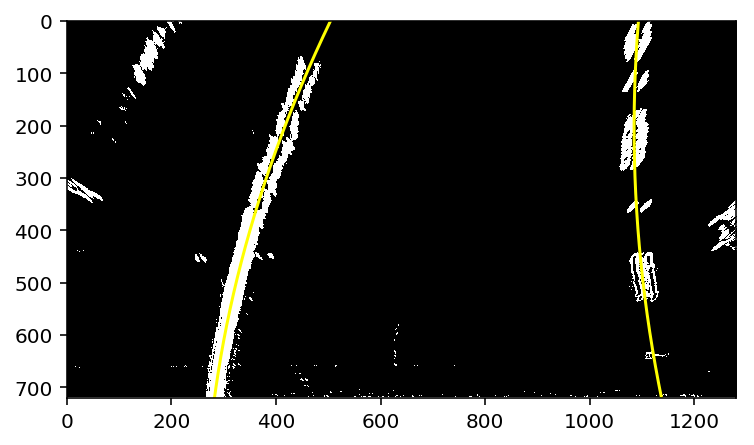

In [262]:
import os.path

#Step 1 - Caliberate Camera
if dist_cof is None or camera_matx is None:    
    print("Caliberating Camera. Please wait...")
    camera_images_pattern = "./camera_cal/calibration*.jpg"
    images = glob.glob(camera_images_pattern)
    ret, camera_matx, dist_cof = caliberate_camera(images, draw=DEBUG)
    print("Caliberation Done.")
else:
    print("Using existing camera caleberation")

assert camera_matx is not None
assert dist_cof is not None

#Step 2 - Load Video
def process_image(img, draw=False, img_name=None):
    return detect_lane(img, draw=draw, img_name=img_name)

if DEBUG == True:
    images = glob.glob("./test_images/*.jpg")
    for each in images:
        img = cv2.imread(each)
        img = process_image(img, draw=DEBUG, img_name=os.path.basename(each))
        cv2.imwrite("./output_images/lane_{0}".format(os.path.basename(each)), img)
else:    
    video_out = 'project_out.mp4'
    clip = VideoFileClip("project_video.mp4")
    out_clip = clip.fl_image(process_image)
    %time out_clip.write_videofile(video_out, audio=False)

#for every frame try to find lane and dra
print("....... DONE .........")

In [182]:
HTML("""
<video width="960" height="540" controls>
  <source src="project_out.mp4">
</video>
""")